# Surveillance cameras EDA

Camille Seaberry

## About the datasets

Annotation data was collected from the original data sources (Sheng et al and Objects365), cleaned up on the Roboflow platform, and re-exported in COCO format. I later added the training set of Mapillary's Vista dataset, an open source alternative to Google Street View with downloads freely available of research images. 

There are two datasets here, one of full images possibly containing more than one camera in the frame (for object detection), and one of images cropped to just the bounding box of a single camera instance (for image classification). To get the cropped images, I uploaded the full images to Roboflow, where I was able to crop images to just their bounding boxes; I did this just for the Street View images, because those are the only images with classes of cameras labeled.

Note that because of the number of images and their size, for now they're kept out of the github repo. In addition to the training set I analyze here, both datasets also have test and validation splits.

## Housekeeping

In my previous EDA, I used the datasets that I'd cleaned, augmented, and reexported on Roboflow. I've now redownloaded images from their sources in order to focus on the images themselves before looking at the metadata. One issue with this is that the metadata from the Stanford study on Street View images uses panorama IDs; because Google is constantly updating their imagery, these IDs can go out of circulation. I believe this is why I was more recently getting a lot of image downloads coming back blank (just a gray image with an error message on it). I've now removed those images based on their file size (see src/prep_meta.py). Objects365 images are the same. Mapillary Vista images are a new addition, and a larger dataset than either of the other two sources.

In [25]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import json
import cv2
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pprint import pprint
import seaborn as sns
import seaborn.objects as so
import warnings

from settings import ROOT_DIR

ROOT_DIR = Path(ROOT_DIR)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
def show_cv(img, conv = cv2.COLOR_BGR2RGB, cmap = None, title = None):
    plt.imshow(cv2.cvtColor(img, conv), cmap = cmap)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

def img_grid(imgs, 
             nrow = 2, 
             figsize = (10, 10), 
             conv = cv2.COLOR_BGR2RGB, 
             cmap = None, 
             title = None):
    if conv is not None:
        imgs = [cv2.cvtColor(img, conv) for img in imgs]
    
    n = len(imgs)
    ncol = int(np.ceil(n / nrow))
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = figsize)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j < n:
                ax[i, j].imshow(imgs[i * ncol + j], cmap = cmap)
                ax[i, j].axis('off')
    
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    

In [27]:
def check_img(path):
    if not path.exists():
        return False
    return True

def safe_read_cv(path):
    # check if path exists
    if check_img(path):
        return cv2.imread(str(path))
    else:
        return np.array([])

def quiet_read_txt(path, usecols = (1, 2, 3, 4), **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        txt = np.loadtxt(path, usecols = usecols, **kwargs)
    return txt

## EDA on training data

### Metadata

Beyond the data encoded in images, much of the information about the dataset comes from the annotations. For full-sized images (detection task), these were originally in COCO JSON format, then exported from Roboflow in [YOLOv8 format](https://roboflow.com/formats/yolov8-pytorch-txt); for cropped (classification task) these are in folders by class. This will allow both to be read easily by Pytorch. Note that YOLO format gives bounding boxes as the box's normalized center x, center y, width, and height.

By far, most images have just 1 bounding box, but a few images have 20 or more boxes; images with many boxes tend to be indoor scenes from Object365. When creating the datasets on Roboflow, I included a filter that requires at least 85% of images in each set have a bounding box in order to deal with the way the Vista images were cut. 11% of images have no bounding boxes. On average, bounding boxes only take up about 2% of the width and height of the image; this is why I am also working with a tiled version of the images.

Cropped images contain one of two classes, either globe cameras or directed cameras. There are slightly more directed cameras than globe cameras across each split. One important note is that because the cameras within images are so small, the cropped images tend to be very small. YOLO has a minimum size needed for classification, and many of the cropped images are too small. Directed cameras tend to be much wider than they are tall, while globe cameras have bounding boxes closer to square.

In [28]:
#| label: lbl-meta
# images setup is changed, so do EDA from image & label folders
# img_meta: one row per image
img_globs = (ROOT_DIR / 'data/comb_full/train/images').glob('*.jpg')
img_meta = pd.DataFrame({ 'img_path': list(img_globs) })
img_meta['id'] = img_meta['img_path'].apply(lambda x: x.stem)
img_meta['lbl_path'] = img_meta['id'].apply(lambda x: ROOT_DIR / 'data/comb_full/train/labels' / f'{x}.txt')

# read each label file, ignoring empty input file warnings
img_meta['bbox'] = img_meta['lbl_path'].apply(lambda x: quiet_read_txt(x, unpack = True))
img_meta['bbox'] = img_meta['bbox'].apply(lambda x: x.reshape(-1, 4))
img_meta['n_boxes'] = img_meta['bbox'].apply(lambda x: len(x))
img_meta['cv'] = img_meta['img_path'].apply(lambda x: safe_read_cv(x))
img_meta['shape'] = img_meta['cv'].apply(lambda x: x.shape)

# lbl_meta: one row per bounding box
lbl_meta = img_meta.explode('bbox')
lbl_meta = lbl_meta.set_index('id')
lbl_meta = lbl_meta['bbox'].apply(pd.Series)
lbl_meta.columns = ['x', 'y', 'w', 'h']
lbl_meta.head()

,x,y,w,h
id,,,,
jr5tX8IrUx1b6JGw7TzGPw_jpg.rf.91a83d31193335775ff28d05edf133ac,0.889062,0.721875,0.060937,0.314844
jr5tX8IrUx1b6JGw7TzGPw_jpg.rf.91a83d31193335775ff28d05edf133ac,0.010156,0.010156,0.024219,0.015625
objects365_v1_00000926_jpg.rf.0af247e70bf314b1ace00ea1d0b04918,0.315625,0.331250,0.010937,0.012500
IZXqv8lvtYUn1SOfZQ7N9w_269_jpg.rf.817322bfc5e0795c4793f783c53e05fa,0.639844,0.402344,0.014063,0.017188
XXWEd36K6hP98YXNDujDtw_jpg.rf.a91e9cb66cf5aaccdeea2831b038ba06,NaN,NaN,NaN,NaN


Average image width and height by type, cropped training images

In [29]:
#| label: crop-meta
# cropped image metadata
crop_globs = (ROOT_DIR / 'data/cams_crop/train').glob('**/*.jpg')
crop_meta = pd.DataFrame({ 'img_path': list(crop_globs) })
crop_meta['cv'] = crop_meta['img_path'].apply(lambda x: safe_read_cv(x))
crop_meta['shape'] = crop_meta['cv'].apply(lambda x: x.shape)
crop_meta['type'] = crop_meta['img_path'].apply(lambda x: x.parent.stem)
crop_meta['h'] = crop_meta['shape'].apply(lambda x: x[0])
crop_meta['w'] = crop_meta['shape'].apply(lambda x: x[1])

# print('\nAverage image width and height by type, cropped training images')
crop_meta.groupby('type')[['w', 'h']].mean()

,w,h
type,,
directed,13.007737,9.323017
globe,8.590234,10.380042


Summary statistics of image dimensions and bounding box placement, full training images

In [30]:
#| label: dim-stats
# print('\nSummary statistics of image dimensions and bounding box placement, full training images')
lbl_meta.describe()

,x,y,w,h
count,5278.000000,5278.000000,5278.000000,5278.000000
mean,0.379110,0.362457,0.117132,0.120531
std,0.318495,0.324025,0.228987,0.230606
min,0.001563,0.000781,0.000781,0.000781
25%,0.039844,0.035937,0.010156,0.010937
50%,0.335938,0.296094,0.017188,0.020313
75%,0.657031,0.637500,0.044531,0.054688
max,0.998437,0.999219,0.999219,0.999219


In [31]:
def count_by_dir(path: Path):
    ''' 
    Count number of files by directory, returning parent directory as well
    '''
    imgs = path.glob('**/*.jpg')
    parents = set([img.parent for img in imgs])
    counts = {}
    for parent in parents:
        counts[str(parent.stem)] = len(list(parent.glob('*.jpg')))
    return counts
    

In [32]:
n_img_full = {}
n_img_crop = {}
for split in ['train', 'valid', 'test']: # classifier uses val, detector uses valid
    n_img_full[split] = count_by_dir(ROOT_DIR / f'data/comb_full/{split}/')
    
    if split == 'valid':
        folder = 'val'
    else: 
        folder = split
    n_img_crop[split] = count_by_dir(ROOT_DIR / f'data/cams_crop/{folder}/')

print('Count of images by split, full-size images:')
pprint(n_img_full, sort_dicts = False)

print('\nCount of images by split and class, cropped images:')
pprint(n_img_crop, sort_dicts = False)

Count of images by split, full-size images:
{'train': {'images': 4068}, 'valid': {'images': 1155}, 'test': {'images': 617}}

Count of images by split and class, cropped images:
{'train': {'directed': 517, 'globe': 471},
 'valid': {'directed': 75, 'globe': 84},
 'test': {'directed': 47, 'globe': 32}}


Descriptive statistics of number of bboxes per full-size training image

In [33]:
#| label: boxes-per-img
# print('\nDescriptive statistics of number of bboxes per full-size training image:')
img_meta['n_boxes'].describe()

count    4068.000000
mean        1.297443
std         1.304801
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        24.000000
Name: n_boxes, dtype: float64

In [34]:
print('\nPercentage of full-size training images with no bounding boxes:')

f'{(img_meta["n_boxes"] == 0).mean():.0%}'


Percentage of full-size training images with no bounding boxes:


'12%'

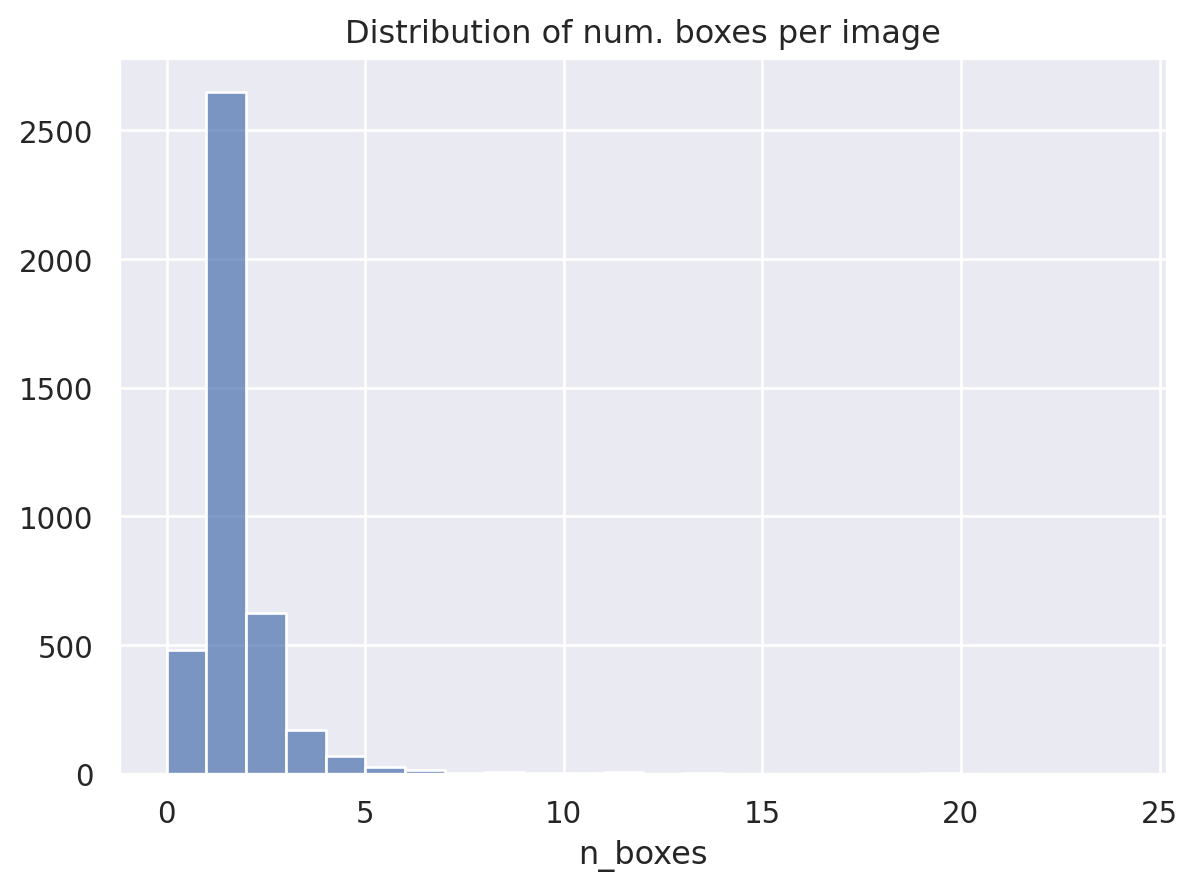

In [35]:
#| label: boxes-dist
(
    so.Plot(img_meta, x = 'n_boxes')
    .add(so.Bars(), so.Hist(binwidth = 1))
    .label(title = 'Distribution of num. boxes per image')
)

The vast majority of images have only 1 or 2 cameras marked in them. Some have upwards of 15; checking for anomalies, it does seem realistic for some indoor scenes from the Objects365 data to have many cameras. For example, of the 6 training images with 15 or more cameras marked, all but 1 are checkout areas of big box stores, so it makes sense that so many cameras would be in close proximity. If there were more of these extreme values I might filter some out, since this is a situation that's unlikely for the Street View images I want to use for inference, but training shouldn't be thrown off by so few images with more than 3 or so cameras.

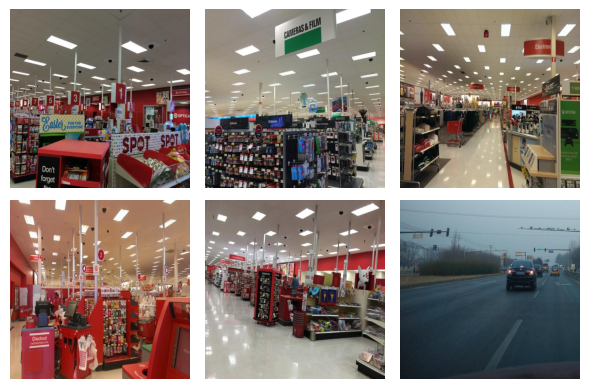

In [36]:
#| label: many-cams
many_cams = img_meta.loc[img_meta['n_boxes'] >= 15, 'cv']
img_grid(many_cams, figsize=(6, 4))

## Analysis of training images for detection

I'm interested in how the images are structured---color, shape, variety. Street images (both Google Street View and Mapillary Vista) in particular have clear patterns by design, with a zoomed out panorama shot of a street that includes the road, sidewalks, buildings, and often a view of the sky, and are generally taken on non-rainy days. The Street View images all come from cities chosen by the Stanford researchers, so they tend to have more gray and beige colors than rural or suburban shots might. Even though the cameras in the Street View images tend to be very small, they're also pretty uniform in color and shape (dark globe or square for the camera, light casing). 

Mapillary images are much larger (median dimensions are 3264 x 2448 pixels), so cameras are larger but also can be washed out by their surroundings. To deal with that, I've kept the first Street View and Objects dataset separate from the Vista one on Roboflow; I then used the platform to tile each Vista image into four smaller ones, making them of more comparable size to the first set. My training script downloads these two datasets separately, then combines them by training / validation / testing splits, making a dataset that is more uniform in size but still varied in content.

### Color

Because these are the types of images I'd like to run inference on, the level of predictability in the structure and colors might be beneficial, because new images will be so reliably similar to the ones the models are trained on. However, this might also have drawbacks: for example, Street View images are taken during the daytime, so a model trained on SV images likely won't perform well at night, and maybe won't do as well in different background (more rural or suburban scenes, indoors, etc).

Here I'm focusing on street scene images because they form a sort of archetype for inference. With a sample of 500 images, I analyze the distribution of colors across the sample with histograms. Within the RGB space, the distributions are most heavily concentrated around middle values of the three channels, with a spike of strong blue colors (presumably because the sky is shown in many photos). 

To look at this differently, I use k-means clustering to boil the images down to their most dominant color (using k = 1), then view the distribution of those dominant colors, most of which are grays and light blues. This isn't necessarily the average of the images' red, green, and blue components, but the point in color space at which the k-means clustering algorithm picked its center. 

Then I posterize images with k = 3, as a qualitative view of not just the one most dominant color, but the top few. Colors are clustered per image, not across the sample, but because of their similarities they all end up with similar palettes predominantly of beige-gray, light blue, and off white.

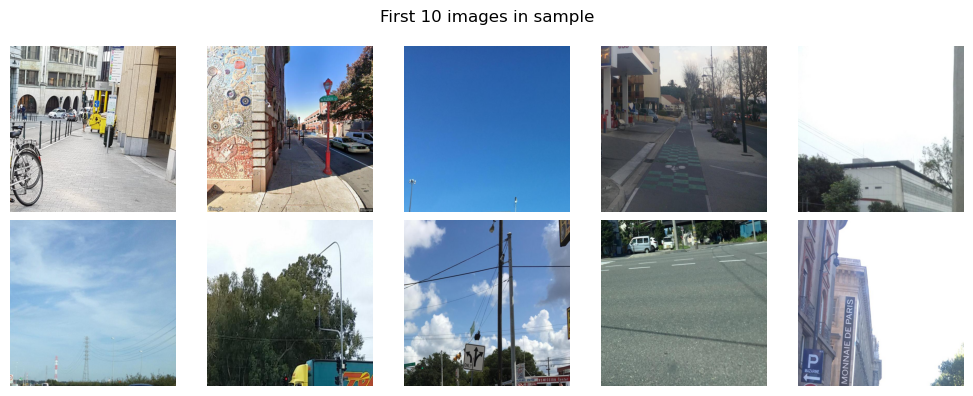

In [37]:
#| label: img-samp
n_samp = 500
svv_samp = img_meta['img_path'].sample(n_samp, random_state = 1).apply(safe_read_cv).apply(lambda x: cv2.resize(x, (640, 640)))
img_grid(svv_samp.iloc[0:10], nrow = 2, figsize = (10, 4),
         title = 'First 10 images in sample')

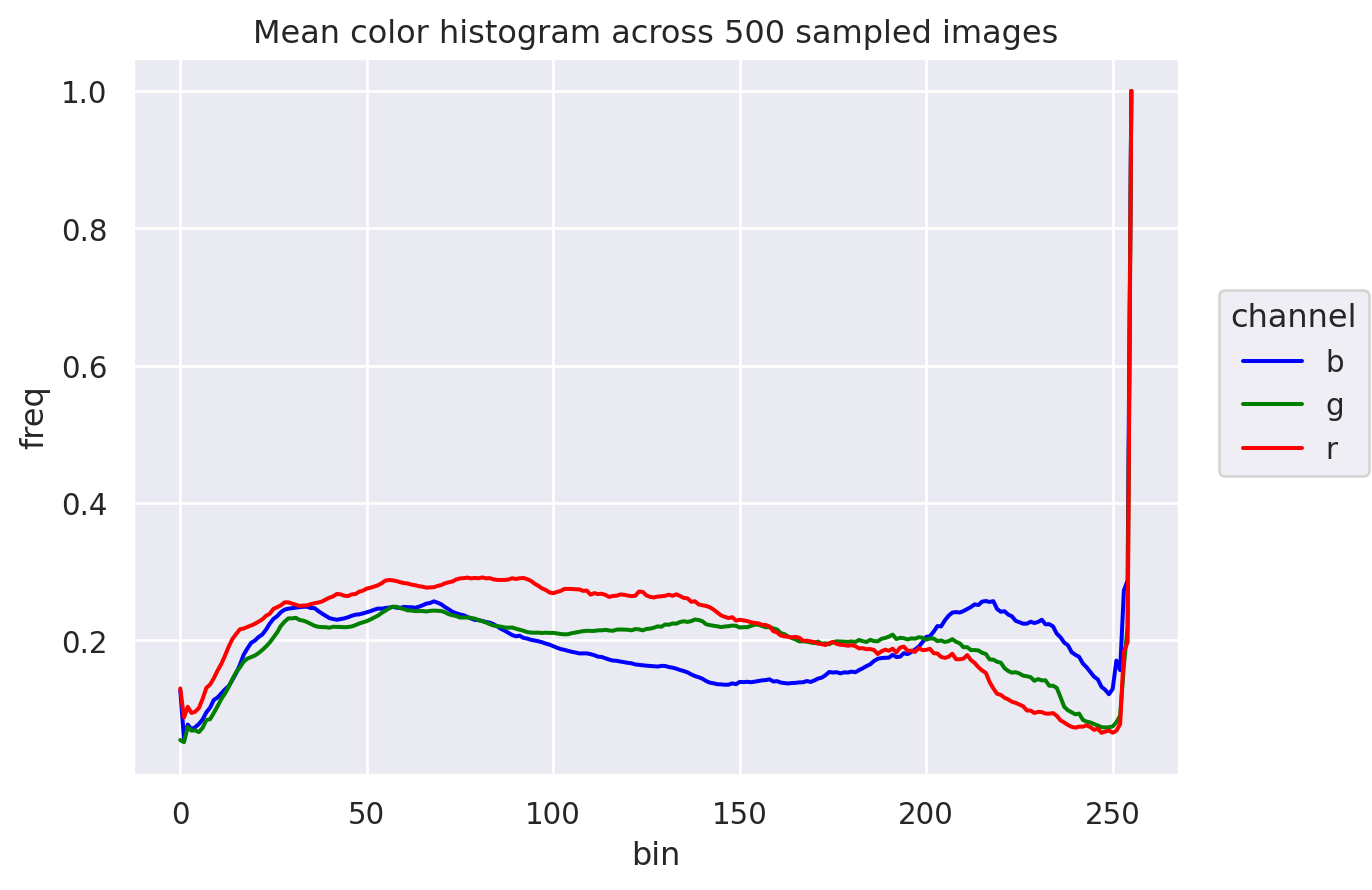

In [38]:
#| label: color-hist
# hists = np.zeros((3, len(sv_samp), 256))
hists = {}
for i, col in enumerate(('b', 'g', 'r')):
    # calcHist returns list of counts at each of 256 bins (each color value)
    hist = np.array([cv2.calcHist([img], 
                                channels = [i],
                                mask = None,
                                histSize = [256],
                                ranges = [0, 256]) for img in svv_samp]).squeeze()
    avg = hist.mean(axis = 0)
    hists[col] = avg / avg.max()

color_hist = pd.DataFrame(hists).reset_index(names = ['bin']) \
    .melt(id_vars = 'bin', var_name = 'channel', value_name = 'freq') 

(
    so.Plot(color_hist, x = 'bin', y = 'freq', color = 'channel')
        .add(so.Line())
        .scale(color = ('blue', 'green', 'red'))
        .label(title = f'Mean color histogram across {n_samp} sampled images')
)

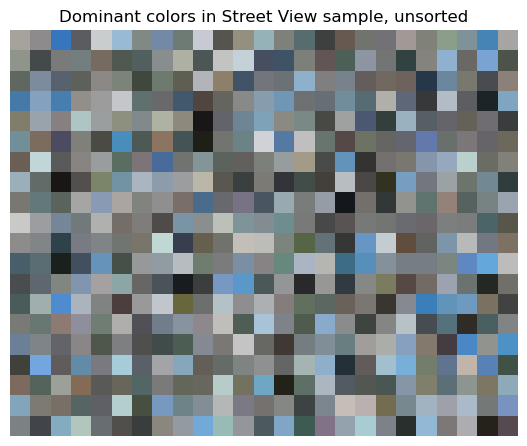

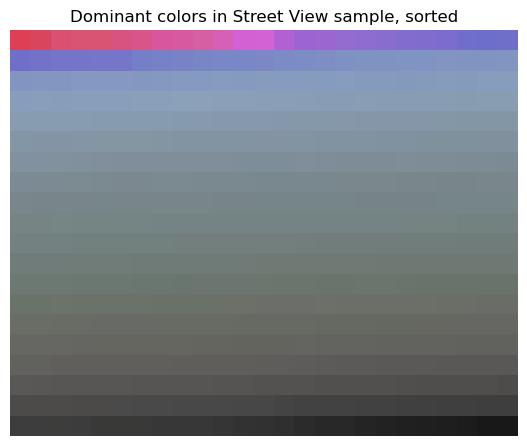

In [39]:
#| label: posterize
def img_kmeans(img, k = 3):
    ''' 
    Implemetation of kmeans clustering on images based on OpenCV docs
    https://docs.opencv.org/4.8.0/d1/d5c/tutorial_py_kmeans_opencv.html
    '''
    img_float = np.float32(img.reshape((-1, 3)))
    crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, labels, centers = cv2.kmeans(img_float, 
                                      K = k, 
                                      bestLabels = None, 
                                      criteria = crit,
                                      attempts = 10,
                                      flags = cv2.KMEANS_RANDOM_CENTERS)
    # centers = np.uint8([centers])
    centers = np.uint8(centers)
    return centers, labels

def main_hsv(img):
    ''' 
    Using kmeans clustering, get the center of a single cluster to represent the image. 
    This converts to HSV color space in order to easily sort colors by hue and lightness. 
    '''
    center, _ = img_kmeans(img, k = 1)
    hsv = cv2.cvtColor(np.array([center]), cv2.COLOR_BGR2HSV)
    return hsv.flatten()

def posterize(img, k = 3):
    centers, labels = img_kmeans(img, k = k)
    result = centers[labels.flatten()].reshape(img.shape)
    return result
    

main_hsv(svv_samp.iloc[0])

img_colors = np.array([main_hsv(img) for img in svv_samp])
show_cv(img_colors.reshape((20, 25, 3)), 
        conv = cv2.COLOR_HSV2RGB, 
        title = 'Dominant colors in Street View sample, unsorted')

# sort img_colors in reverse
img_colors.sort(axis = 0)
img_colors = img_colors[::-1]
show_cv(img_colors.reshape((20, 25, 3)), 
        conv = cv2.COLOR_HSV2RGB, 
        title = 'Dominant colors in Street View sample, sorted')

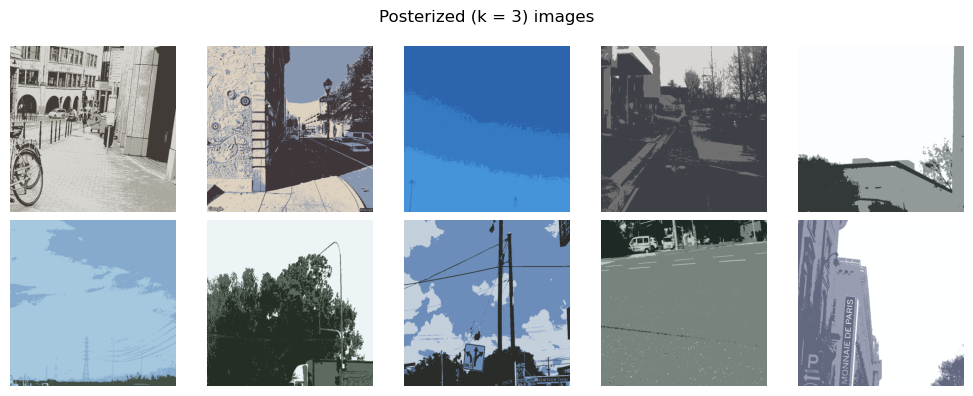

In [40]:
#| label: posterize2
np.random.seed(0)
poster_imgs = np.array([posterize(img) for img in svv_samp.iloc[0:10]])
img_grid(poster_imgs, figsize = (10, 4), title = 'Posterized (k = 3) images')

### Shape

Next I'm interested in the structure of the image scenes. I use principal components analysis (PCA) to reduce grayscale versions of the images to fewer dimensions and mimic the eigenfaces used in facial recognition exercises. The first few components create rather spooky street scenes, with elements that hint at roads, curbs, crosswalks (striping pattern in the forefront), building and windows, shapes that might be overpasses or darker skies, and parked cars. Some also retain the Google watermark in the bottom left corner. The captured PCs can then be used to reconstruct images.

While this helps with understanding the image composition overall, because the cameras are so small I don't think this will be a very useful technique in camera detection.

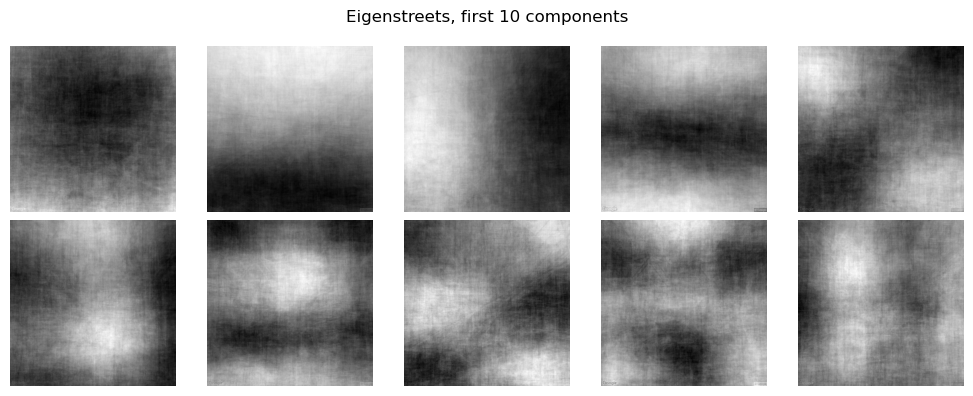

In [41]:
#| label: pca
scaler = StandardScaler(with_mean = True, with_std = True)

imgs_flat = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in svv_samp])
imgs_scale = scaler.fit_transform(imgs_flat)
n_comps = 20
pca = PCA(n_components = n_comps, whiten = True, random_state = 0)
pca.fit(imgs_scale)
eigenstreets = pca.components_.reshape((n_comps, 640, 640))
img_pca = pca.transform(imgs_flat)

img_grid(eigenstreets[0:10],
         nrow = 2, figsize = (10, 4), conv = None, cmap = 'gray', 
         title = 'Eigenstreets, first 10 components')

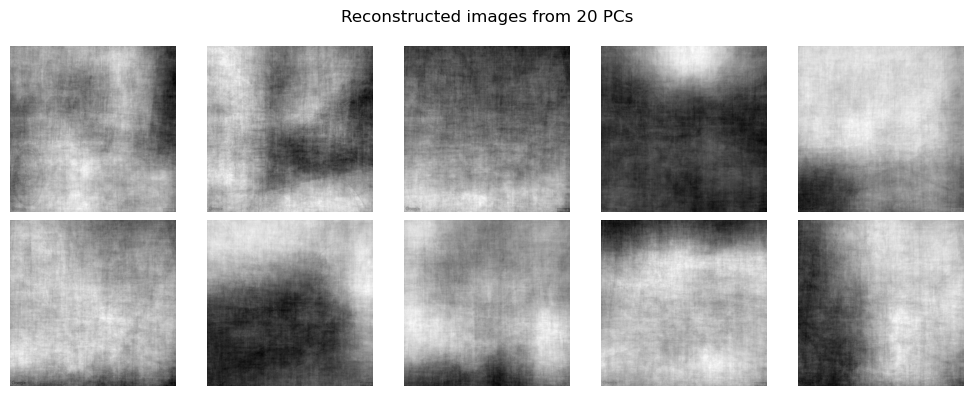

In [42]:
#| label: pca-recon
recon = pca.inverse_transform(img_pca)
img_grid(recon.reshape((500, 640, 640))[0:10],
         nrow = 2, figsize = (10, 4), conv = None, cmap = 'gray',
         title = f'Reconstructed images from {n_comps} PCs')

### Feature mapping 

As a more advanced version of the eigenstreets, I am also curious as to how the images might decompose using simple neural networks. I'll be using more complex pretrained models for object detection later, but for feature mapping a multilayer perceptron will suffice. However, for EDA I'm just trying this out with scikit-learn training a very weak MLP without using my GPU, which yields features similar to the eigenstreets. It's a bit artificial, since for the full size images I don't expect to be doing classification anyway, and only trained on this sample of 500 images without augmentation.

In [43]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import minmax_scale

In [44]:
# label_samp = sv_meta.iloc[sv_samp.index, :]['label']
label_samp = [1 for i in range(n_samp)]
hidden_layers = (64,)
mlp = MLPClassifier(hidden_layer_sizes = hidden_layers,
                    # solver = 'lbfgs',
                    # activation = 'relu',
                    random_state = 1,
                    max_iter = 20)
mlp.fit(imgs_scale, label_samp)

MLPClassifier(hidden_layer_sizes=(64,), max_iter=20, random_state=1)

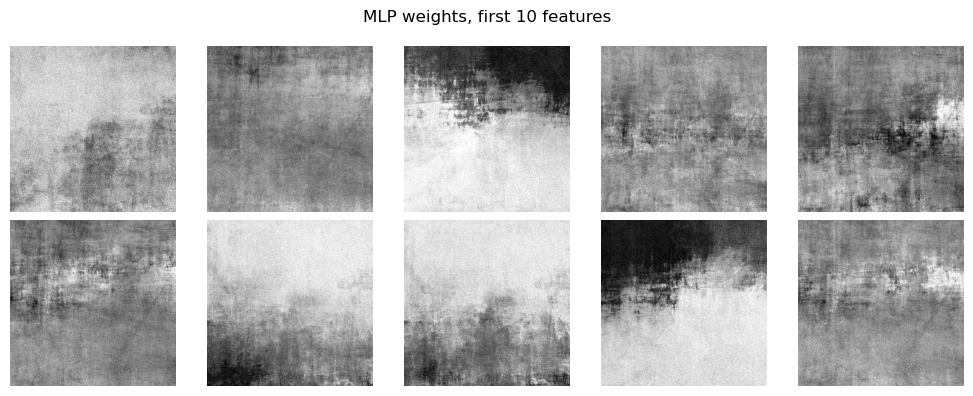

In [45]:
#| label: features
mlp_wts = minmax_scale(mlp.coefs_[0].T)
mlp_shape = (hidden_layers[0], 640, 640)
img_grid(mlp_wts.reshape(mlp_shape)[0:10], nrow = 2, conv = None, figsize = (10, 4), cmap = 'gray',
         title = 'MLP weights, first 10 features')

## Classification

Finally, a sample of some of the cropped images:

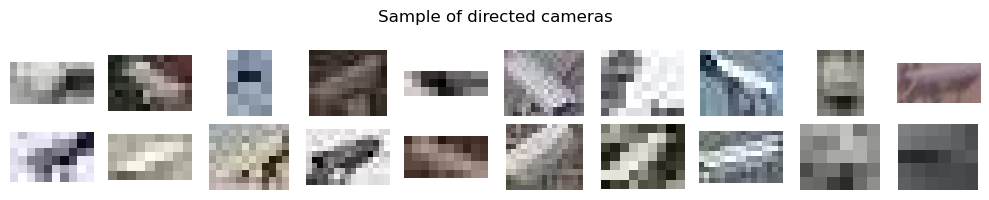

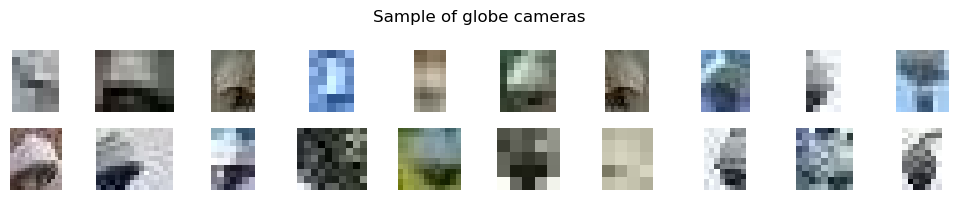

In [46]:
#| label: crop-samp
def sample_crop(n = 50, split = 'train'):
    crop_dir = ROOT_DIR / 'data/cams_crop' / split  
    dirs = crop_dir.glob('*')
    samp_by_class = {}
    for cls in dirs:
        img_paths = list(cls.glob('*.jpg'))
        samp = np.random.choice(img_paths, size = n, replace = False)
        samp_paths = [str(img) for img in samp]
        samp_by_class[str(cls.stem)] = pd.DataFrame(samp_paths, columns = ['path'])
    samp_df = pd.concat(samp_by_class, axis = 0, names = ['category']).reset_index(level = 0)
    samp_df['cv'] = samp_df['path'].apply(lambda x: cv2.imread(x))
    return samp_df

np.random.seed(0)
crop_samp = sample_crop(n = 250)
crop_samp['height'] = crop_samp['cv'].apply(lambda x: x.shape[0])
crop_samp['width'] = crop_samp['cv'].apply(lambda x: x.shape[1])
crop_samp['area'] = (crop_samp['height'] * crop_samp['width']).astype('float')
crop_samp['aspect'] = crop_samp['width'] / crop_samp['height']

# img_grid(crop_samp.iloc[0:20, :]['cv'])
img_grid(crop_samp.loc[crop_samp['category'] == 'directed', 'cv'][0:20], 
         nrow = 2, figsize = (10, 2), title = 'Sample of directed cameras')

img_grid(crop_samp.loc[crop_samp['category'] == 'globe', 'cv'][0:20], 
         nrow = 2, figsize = (10, 2), title = 'Sample of globe cameras')


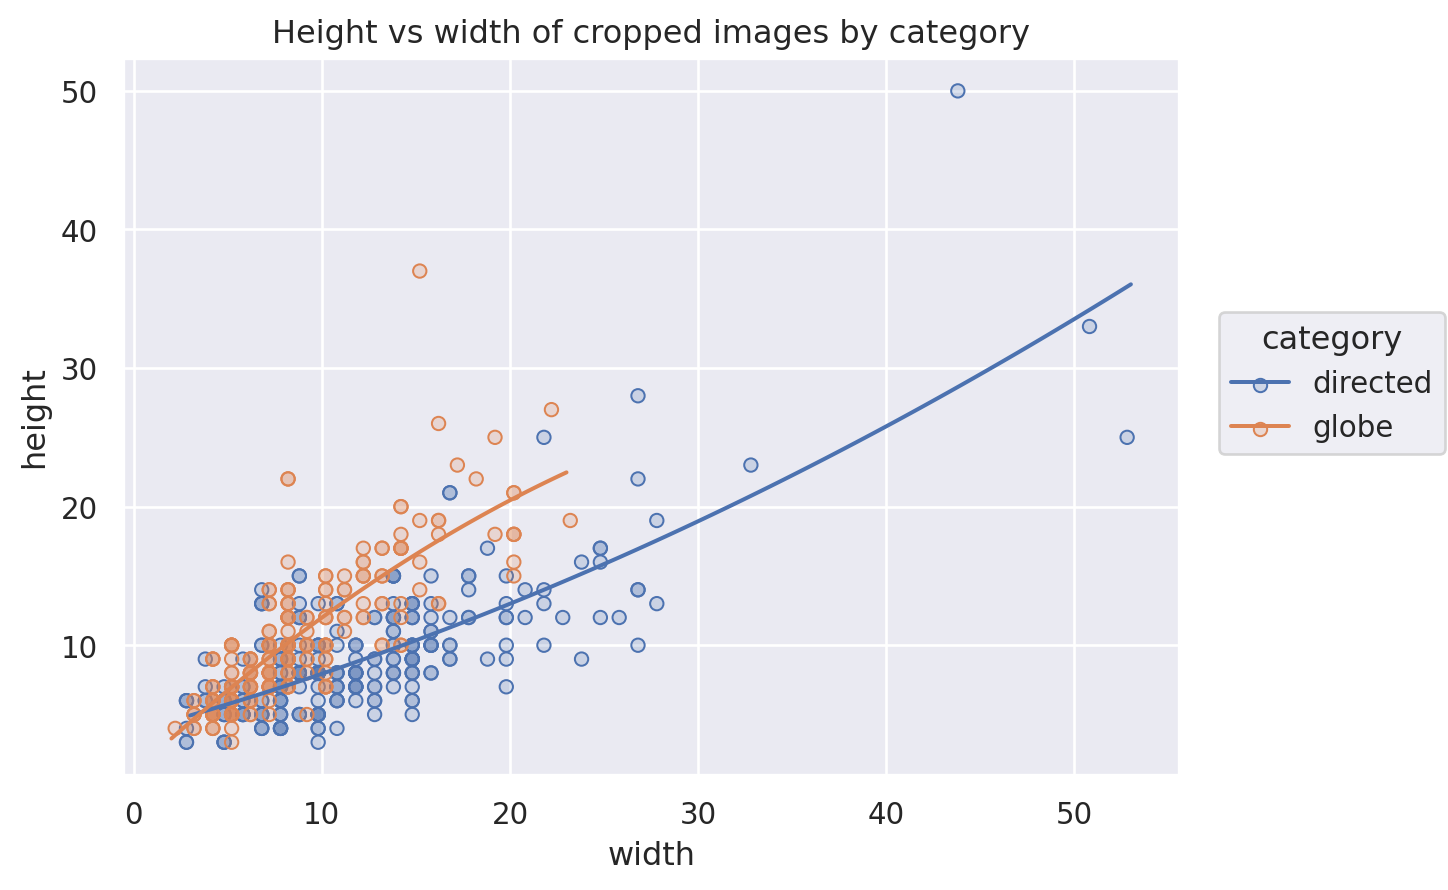

In [47]:
#| label: crop-scatter
(
    so.Plot(crop_samp, x = 'width', y = 'height', color = 'category')
        .add(so.Dots(pointsize = 5), so.Dodge())
        .add(so.Line(), so.PolyFit())
        .label(title = 'Height vs width of cropped images by category')
)

While I'll be using deep learning for both object detection and classification, the bounding boxes seem like they might be varied enough by category to use simpler machine learning techniques to build a reasonable classifier. For example, with no tuning, both naive bayes and random forest classifiers perform fairly well.

In [48]:
#| label: crop-models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# scaler = StandardScaler(with_mean = True, with_std = True)
nb = GaussianNB()
rf = RandomForestClassifier()
X = crop_samp.loc[:, ['width', 'height', 'area', 'aspect']]
y = crop_samp['category']
nb.fit(X, y)
rf.fit(X, y)
print(f'naive bayes classifier score: {nb.score(X, y)}')
print(f'random forest classifier score: {rf.score(X, y)}')

naive bayes classifier score: 0.75
random forest classifier score: 0.88
